<h1> Image segmentation with neural networks</h1>

In this notebook, I will attempt some advanced image segmentation using neural networks. This notebook was run as a Google Colab Notebook for inference.

For a comparison with traditional kernel-based solutions, see `image_segmentation.ipynb`.

This notebook has been adapted from https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DPT

For a custom, UNet-based image segmentation, see `img_segment_unet.ipynb`

<h2> What are Transformers? </h2>

If Optimus Prime was the first thing to pop in your mind, you would be technically correct but not contextually correct. That is the purpose of Transformers, which are a kind of neural network that learn context and can derive meanings from those contexts. As a result, they are able to correctly interpret and predict sequential elements, like words in a sentence.

Transformers can be trained on a wide variety of data: images, text, signals, quantitative information, etc. Often they are applied in NLP problems such as sentiment analysis, extraction of information in a text and chatbots. In this notebook, I will focus on using a transformer model called Dense Prediction Transformer, or DPT for short. DPTs can be used in place of Convolutional Neural Networks (CNNs) for tasks like depth estimation or semantic segmentation in an image. Semantic segmentation is a task in which both feature extraction and image classification are performed on the same image.

Although the full capabilities of DPT are not explored in this notebook, it showcases how powerful it is in the task of image segmentation especially in cases where traditional thresholding techniques fail.

<h3> Why Neural Networks? </h3>

In a previous demo of mine, `image_segmentation.ipynb`, I used two popular techniques to segment an image: a classic Otsu method algorithm and a simple thresholding and filtering technique. Both methods performed fairly well, however the parameters chosen are not trivial to determine and require time in the experimentation process to perfect.

Neural networks remove this ambiguity entirely. By training a neural network to perform segmentation, it removes the user bias entirely (although it comes back in another form, mainly in the training set). This saves the user time in finetuning thresholding parameters and also increases the likelihood of success in the segmentation process.

## Set-up environment
Installing the transformers package

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 101 kB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 39.2 MB/s 
     |████████████████████████████████| 596 kB 55.1 MB/s 


## Define model

Using the DPT model for segmentation

In [2]:
from transformers import DPTForSemanticSegmentation
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np
from PIL import Image
import torch
import cv2
from google.colab.patches import cv2_imshow

model = DPTForSemanticSegmentation.from_pretrained("Intel/dpt-large-ade")

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked']
You should probably TRAIN this mo

<h3> Importing Test Image </h3>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


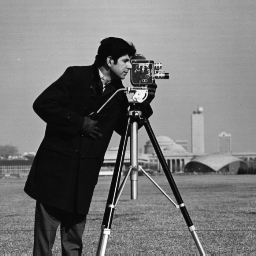

In [4]:
img_path = '/content/gdrive/My Drive/Colab Notebooks/Data/test2.jpg'

image = Image.open(img_path).convert('RGB')
image

Here we define a transform function that prepares our image to be used in the inferer. The network is trained on images of size 480x480 therefore images must be resized accordingly. Image pixel values in all three colour channels (if present) are also normalized to the values shown below (`mean=0.5` and `std=0.5`).

In [5]:
net_h = net_w = 480

transform = Compose([
        Resize((net_h, net_w)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

pixel_values = transform(image).unsqueeze(0)

<h3> Inference Step </h3>

This is where the actual prediction happens. The output `prediction` is a numpy array that contains the ID of each entity in the image. This is the key difference between feature extraction, semantic segmentation and image classification. A feature extractor may provide entity boundaries but no ID. An image classifier may provide entity IDs but no boundaries. A semantic segmentation model will provide both IDs and boundaries of entities!

In [6]:
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

logits.shape

torch.Size([1, 150, 480, 480])

In [7]:
# interpolate logits to original size
prediction = torch.nn.functional.interpolate(
                logits, 
                size=image.size[::-1], 
                mode="bicubic", 
                align_corners=False
            )
prediction = torch.argmax(prediction, dim=1) + 1
prediction = prediction.squeeze().cpu().numpy()
prediction

array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]])

Converting the matrix of semantic segmentation to a colour pallette

In [8]:
adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,
140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,
143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,
9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,
255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,
0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,
0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,
194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,
0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255
,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,
235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,
70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,
122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,
255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

Here we overlay the colour pallette version of the prediction matrix with the original image

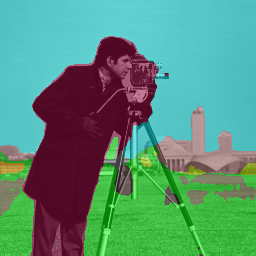

In [9]:
predicted_seg = Image.fromarray(prediction.squeeze().astype('uint8'))
predicted_seg.putpalette(adepallete)

out = Image.blend(image, predicted_seg.convert("RGB"), alpha=0.5)
out

Wow!! These results are amazing. Neural networks work great for edge cases not easily covered by algorithms that apply basic filter techniques.

We will now attempt to use the image segmentation results to mask out the background and leave only the photographer.

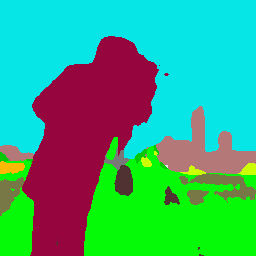

In [10]:
predicted_seg

The original prediction result is a matrix where each number identifies a unique segment in the image. We are able to determine that `13` is the identifier for the photographer and we construct a mask based on that. Then, we apply the mask to our image with a simple element-wise multiplication.

In [11]:
np.unique(prediction)
# 13 is the photographer

array([ 1,  2,  3,  4,  5,  9, 10, 13, 14, 18, 33])

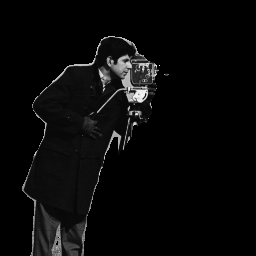

In [13]:
mask = (prediction == 13).astype(np.int_) 
img = cv2.imread(img_path, 0)
result = mask*img

cv2_imshow(result)

<h3> Extra code to save image and model files for faster loading </h3>

In [20]:
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/Data/predicted_seg.png', np.array(predicted_seg))
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/Data/out.png', np.array(out))
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/Data/mask.png', np.array(mask))
cv2.imwrite('/content/gdrive/My Drive/Colab Notebooks/Data/result.png', np.array(result))

True

In [21]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/Colab Notebooks/Data/dpt_model.pth')